In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [36]:
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? False


In [37]:
train_transforms = transforms.Compose(
    [
        transforms.RandomApply(
            [
                transforms.CenterCrop(22),
            ],
            p=0.1,
        ),
        transforms.Resize((28, 28)),
        transforms.RandomRotation((-15.0, 15.0), fill=0),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
kwargs = {
    "batch_size": 64,
    "shuffle": True,
    "num_workers": 2,
    "pin_memory": True,
}
train_data = datasets.MNIST(
    "../data", train=True, download=True, transform=train_transforms
)

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [38]:
batch_size = 512
test_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1325,), (0.3105,))]
)
test_data = datasets.MNIST(
    "../data", train=False, download=True, transform=test_transforms
)
kwargs = {
    "batch_size": batch_size,
    "shuffle": True,
    "num_workers": 2,
    "pin_memory": True,
}
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

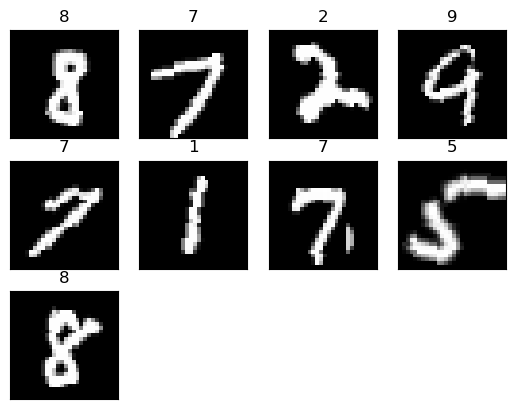

In [39]:
batch_data, batch_label = next(iter(train_loader))
for i in range(9):
    plt.subplot(3, 4, i + 1)
    plt.imshow(batch_data[i].squeeze(),cmap='gray')
    plt.title(batch_label[i].item())
    plt.xticks([])
    plt.yticks([])